In [1]:
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 9
matplotlib.rcParams['ytick.labelsize'] = 9
matplotlib.rcParams['axes.labelsize'] = 9
matplotlib.rcParams['axes.titlesize'] = 10

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.5'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.bottom'] = True


matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.weight']='ultralight'
# matplotlib.rcParams['font.sans-serif'] = ['Computer Modern Sans Serif']
matplotlib.rcParams['axes.axisbelow'] = True

In [3]:
import glob
from matplotlib import pyplot as plt
from matplotlib import gridspec
import numpy as np
from Bio import SeqIO
from scipy import stats
import re
import random
import pandas as pd
import json

from Bio.Data import CodonTable
import itertools
from collections import Counter

from bisect import bisect

In [4]:
def get_codon_dicts(n=11):
    GivenCodonTable = CodonTable.unambiguous_dna_by_id[n]
    nucleotides = ['A', 'T', 'C', 'G']
    aa_to_codons = {}
    for first in nucleotides:
        for second in nucleotides:
            for third in nucleotides:
                Codon = first + second + third
                if Codon not in CodonTable.unambiguous_dna_by_id[n].stop_codons:
                    if GivenCodonTable.forward_table[Codon] in aa_to_codons.keys():
                            aa_to_codons[GivenCodonTable.forward_table[Codon]].append(Codon)
                    else:
                        aa_to_codons[GivenCodonTable.forward_table[Codon]] = [Codon]
                else:
                    pass
    codon_to_aa = {}
    for aa, syns in aa_to_codons.items():
        for syn in syns:
            codon_to_aa[syn] = aa
    return aa_to_codons, codon_to_aa

aa_to_codon_dict, codon_to_aa_dict = get_codon_dicts()

temp = []
for aa in ['P', 'T', 'A', 'V', 'G']:
    temp.extend(aa_to_codon_dict[aa])

redundant_codons = ['CTA', 'CTG', 'CTC', 'CTT',\
                    'TCA', 'TCG', 'TCC', 'TCT',\
                    'CGA', 'CGG', 'CGC', 'CGT'] + temp


# Get the sequences for each gene for testing purposes later
Note: this requires establishing a reference genome that you will use later

In [5]:
base_genome = '511145.12' #This is E. coli K12
species_name = 'Escherichia'
seq_dicty = {}
for infile_name in glob.glob('../Data/Orthologs/Order_Enterobacterales_Mixed/mfastas_nt/*.mfasta'):
    gene_name = infile_name.split('/')[-1].strip('.mfasta')
    records = list(SeqIO.parse(infile_name, 'fasta'))
    for record in records:
        try:
            seq_dicty[record.id][gene_name] = str(record.seq)
        except KeyError:
            seq_dicty[record.id] = {}
            seq_dicty[record.id][gene_name] = str(record.seq)
print('Number of records: {}'.format(len(seq_dicty.keys())))

Number of records: 61


In [6]:
#######To analyze a different genome as a reference, run this cell instead and 
#######just pretend that it's E. coli which makes the code easier
# base_genome = '511145.12' #This is E. coli K12
# new_base_genome = '214092.21'
# species_name = 'Yersinia'
# seq_dicty = {}
# # for infile_name in glob.glob('../Data/Orthologs/Order_Enterobacterales_Reference/mfastas_nt/*.mfasta'):
# # for infile_name in glob.glob('../Data/Orthologs/Order_Enterobacterales_Representative/mfastas_nt/*.mfasta'):
# for infile_name in glob.glob('../Data/Orthologs/Order_Enterobacterales_Mixed/mfastas_nt/*.mfasta'):
# #     print(infile_name)
#     gene_name = infile_name.split('/')[-1].strip('.mfasta')
#     records = list(SeqIO.parse(infile_name, 'fasta'))
#     for record in records:
#         if record.id not in [base_genome, new_base_genome]:
#             try:
#                 seq_dicty[record.id][gene_name] = str(record.seq)
#             except KeyError:
#                 seq_dicty[record.id] = {}
#                 seq_dicty[record.id][gene_name] = str(record.seq)
#         elif record.id == base_genome:
#             try:
#                 seq_dicty[new_base_genome][gene_name] = str(record.seq)
#             except KeyError:
#                 seq_dicty[new_base_genome] = {}
#                 seq_dicty[new_base_genome][gene_name] = str(record.seq)
#         elif record.id == new_base_genome:
#             try:
#                 seq_dicty[base_genome][gene_name] = str(record.seq)
#             except KeyError:
#                 seq_dicty[base_genome] = {}
#                 seq_dicty[base_genome][gene_name] = str(record.seq)
                
# print(len(seq_dicty.keys()))

## And get dicts to identify conserved amino acid positions and consensus nucleotides

Please note that I'm considering an amino acid here as being "conserved" if 60 positions in the alignment have that same amino acid (and it's not a gap). There are 61 total positions so this just gives a little bit of flexibility to definition of conserved.

In [7]:
conservation_dicty = {}
nt_consensus_dicty = {}
nt_conservation_dicty = {}
for infile_name in glob.glob('../Data/Orthologs/Order_Enterobacterales_Mixed/mfastas_nt/*.mfasta')[:]:
    gene_name = infile_name.split('/')[-1].strip('.mfasta')
    conservation_dicty[gene_name] = []
    nt_consensus_dicty[gene_name] = []
    nt_conservation_dicty[gene_name] = []
    records = list(SeqIO.parse(infile_name, 'fasta'))
    aa_seq_lol = []
    nt_seq_lol = []
    ref_genome_aa = []
    ref_genome_nt = []
    for record in records:
        aa_seq_lol.append(list(str(record.seq.translate(gap='-'))))
        nt_seq_lol.append(list(str(record.seq)))
        if record.id == base_genome:
            ref_genome_aa = list(str(record.seq.translate(gap='-')))
            ref_genome_nt = list(str(record.seq))
    aa_seq_lol = np.array(aa_seq_lol)
    aa_seq_lol = aa_seq_lol.T
    for i, pos in enumerate(aa_seq_lol):
        counter_dict = Counter(pos)
        best = sorted(counter_dict.items(), key=lambda x: x[1])[-1]
        if len(counter_dict.keys()) == 1 and counter_dict[list(counter_dict.keys())[0]] != '-':
            conservation_dicty[gene_name].append('C')
        elif len(counter_dict.keys()) == 2 and best[1]==60 and\
                best[0]!='-' and best[0]==ref_genome_aa[i]:
            conservation_dicty[gene_name].append('C')
        else:
            conservation_dicty[gene_name].append('V')
    nt_seq_lol = np.array(nt_seq_lol)
    nt_seq_lol = nt_seq_lol.T
    for i,pos in enumerate(nt_seq_lol):
        counter_dict = Counter(pos)
        nt_consensus_dicty[gene_name].append(sorted(counter_dict.items(), key=lambda x: x[1])[-1][0])
        best = sorted(counter_dict.items(), key=lambda x: x[1])[-1]
        if len(counter_dict.keys()) == 1 and counter_dict[list(counter_dict.keys())[0]] != '-':
            nt_conservation_dicty[gene_name].append('C')
        elif len(counter_dict.keys()) == 2 and best[1]==60 and\
                best[0]!='-' and best[0]==ref_genome_nt[i]:
            nt_conservation_dicty[gene_name].append('C')
        else:
            nt_conservation_dicty[gene_name].append('V')

# Read in substitution rate datasets as separate dictionaries

In [8]:
# dicty_phylop = {}
# for infile_name in glob.glob('../Results/Order_Enterobacterales_Mixed/phyloP_CONACC/*.wig')[:]:
#     with open(infile_name, 'r') as infile:
#         tempy = infile.readlines()
#         data = [float(i) for i in tempy[1:]]
#         dicty_phylop[infile_name.split('/')[-1].strip('.wig')] = data
# print(len(dicty_phylop.keys()))

In [9]:
dicty_hyphy = {}
for infile_name in glob.glob('../Results/Order_Enterobacterales_Mixed/Hyphy_GTR/*.site-rates.json')[:]:
    gene_name = infile_name.split('/')[-1].strip('.site-rates.json')
    with open(infile_name) as infile:
        site_rate_data = json.load(infile)
    positions = [int(i) for i in site_rate_data['Relative site rate estimates'].keys()]
    rates = []
    for position in range(min(positions), max(positions)+1):
        rates.append(site_rate_data['Relative site rate estimates'][str(position)]['MLE'])
    meany = np.mean(rates)
    dicty_hyphy[gene_name] = [i/meany for i in rates]
print(len(dicty_hyphy.keys()))

1394


## Trim 5' terminal gaps according to the E. coli reference sequence for all dicts instantiated above

In [10]:
print(np.mean([len(i) for i in seq_dicty[base_genome].values()]))
print(np.mean([len(i) for i in dicty_hyphy.values()]))

for i, j in seq_dicty[base_genome].items():
    if j[0:3] == '---':
        first_bases = []
        for base in ['A', 'T', 'G', 'C']:
            first_bases.append(j.find(base))
        first_base = min(first_bases)
        
        for genome in seq_dicty.keys():
            seq_dicty[genome][i] = seq_dicty[genome][i][first_base:]
        
        if i in dicty_hyphy.keys():
            dicty_hyphy[i] = dicty_hyphy[i][first_base:]

        if i in conservation_dicty.keys():
            conservation_dicty[i] = conservation_dicty[i][int(first_base/3):]
                
        if i in nt_consensus_dicty.keys():
            nt_consensus_dicty[i] = nt_consensus_dicty[i][first_base:]
            
        if i in nt_conservation_dicty.keys():
            nt_conservation_dicty[i] = nt_conservation_dicty[i][first_base:]
            
print(np.mean([len(i) for i in seq_dicty[base_genome].values()]))
print(np.mean([len(i) for i in dicty_hyphy.values()]))

1105.7195122
1105.7195122
1059.24533716
1059.24533716


## And 3' terminal gaps according to the E. coli reference sequence

In [11]:
print(np.mean([len(i) for i in seq_dicty[base_genome].values()]))
print(np.mean([len(i) for i in dicty_hyphy.values()]))


for i, j in seq_dicty[base_genome].items():
    if j[-3:] == '---':
        last_bases = []
        for base in ['A', 'T', 'G', 'C']:
            last_bases.append(j[::-1].find(base))
        last_base = min(last_bases)
        for genome in seq_dicty.keys():
            seq_dicty[genome][i] = seq_dicty[genome][i][:len(j)-last_base]

        if i in dicty_hyphy.keys():
            dicty_hyphy[i] = dicty_hyphy[i][:len(j)-last_base]

        if i in conservation_dicty.keys():
            conservation_dicty[i] = conservation_dicty[i][:int((len(j)-last_base)/3)]

        if i in nt_consensus_dicty.keys():
            nt_consensus_dicty[i] = nt_consensus_dicty[i][:len(j)-last_base]
        
        if i in nt_conservation_dicty.keys():
            nt_conservation_dicty[i] = nt_conservation_dicty[i][:len(j)-last_base]
            
print(np.mean([len(i) for i in seq_dicty[base_genome].values()]))
print(np.mean([len(i) for i in dicty_hyphy.values()]))

1059.24533716
1059.24533716
1046.48995696
1046.48995696


# Investigate relationships between the metrics on the full dataset

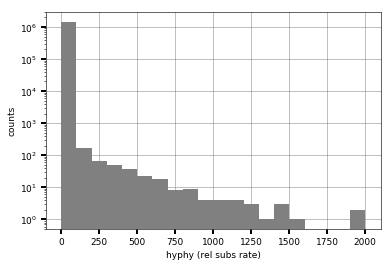

In [12]:
hyphy = []
for key, val in dicty_hyphy.items():
    hyphy.extend(dicty_hyphy[key])   
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(hyphy, 20, color='gray', alpha=1)
ax.set_xlabel('hyphy (rel subs rate)')
ax.set_yscale('log')
ax.set_ylabel('counts')

# Look at length and position-dependent scores

In [13]:
ivals = []
plot_vals_hyphy = []

for i in range(150):
    tempy = []
    for gene_name, vals in dicty_hyphy.items():
        if len(vals) > 150:
            tempy.extend([vals[i]])
    plot_vals_hyphy.append(np.median(tempy))
    
    ivals.append(i)
    
ivals_r = []
plot_vals_hyphy_r = []
for i in range(150, 0, -1):
    tempy = []
    for gene_name, vals in dicty_hyphy.items():
        if len(vals) > 150:
            tempy.extend([vals[-i]])
    plot_vals_hyphy_r.append(np.median(tempy))
    ivals_r.append(-i)

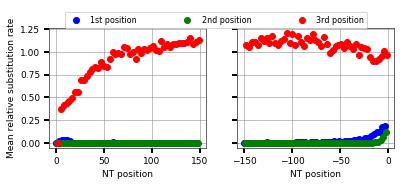

In [14]:
fig = plt.figure(figsize=(6,2.5))
ax1 = fig.add_subplot(121)
l1, = ax1.plot(ivals[0::3], plot_vals_hyphy[0::3], 'bo', label='1st codon position')
l2, = ax1.plot(ivals[1::3], plot_vals_hyphy[1::3], 'go', label='2nd codon position')
l3, = ax1.plot(ivals[2::3], plot_vals_hyphy[2::3], 'ro', label='3rd codon position')
ax1.set_ylabel('Mean relative substitution rate')
ax1.set_xlabel('NT position')
ax2 = fig.add_subplot(122, sharey=ax1)
ax2.plot(ivals_r[0::3], plot_vals_hyphy_r[0::3], 'bo')
ax2.plot(ivals_r[1::3], plot_vals_hyphy_r[1::3], 'go')
ax2.plot(ivals_r[2::3], plot_vals_hyphy_r[2::3], 'ro')
ax2.set_xlabel('NT position')
plt.setp(ax2.get_yticklabels(), visible=False);
fig.subplots_adjust(top=0.85, left=0.1, right=0.9, bottom=0.18)  # create some space below the plots by increasing the bottom-value
plt.figlegend((l1, l2, l3), ('1st position', '2nd position', '3rd position'), bbox_to_anchor=(0.15, 0.88, 0.7, 0.85), loc=3,
           ncol=3, mode="expand", borderaxespad=0, fontsize=8)
# plt.tight_layout()
plt.savefig('../Results/Figures/position_dependent_rates.pdf')

# Defining a SD threshold strength

In [15]:
with open('../Data/json-energyRef-CCUCCU.txt') as infile:
    fragment_energy_dict = json.load(infile)
asd_seq = 'CCTCCT'

In [16]:
real_utrs = []
include = 20
genome = list(SeqIO.parse('/Users/adamhockenberry/Projects/2017/Genome_database/Data/GBFs/511145.12.PATRIC.gbf', 'genbank'))
for record in genome:
    for feature in record.features[:]:
        if feature.type == 'CDS':
            if feature.location.strand == 1:
                cds = str(record.seq[feature.location.start:feature.location.end])
            elif feature.location.strand == -1:
                cds = str(record.seq[feature.location.start:feature.location.end].reverse_complement())
            if len(cds)%3 != 0 or len(cds) < 100 or cds[-3:] not in ['TAA', 'TGA', 'TAG']:
                continue
            if feature.location.strand == 1:
                real_utrs.append(record.seq[feature.location.start-include:feature.location.start])
            elif feature.location.strand == -1:
                real_utrs.append(record.seq[feature.location.end:feature.location.end+include].reverse_complement())

In [17]:
randomizations = 20
real_utrs = [str(i) for i in real_utrs]
strongest_real = []
strongest_fake = []
strongest_fake_dict = {}
for randomization in range(randomizations):
    strongest_fake_dict[randomization] = []


for utr in real_utrs[:]:
    energy_list = []
    for i in range(0, len(utr)-len(asd_seq)-4):
        fragment = utr[i:i+len(asd_seq)]
        energy = fragment_energy_dict[fragment.replace('T', 'U')]
        energy_list.append(energy)
    strongest_real.append(min(energy_list))
    
    for randomization in range(randomizations):
        energy_list = []
        utr_rand = np.array(list(utr))
        np.random.shuffle(utr_rand)
        utr_rand = ''.join(list(utr_rand))
        for i in range(0, len(utr_rand)-len(asd_seq)-4):
            fragment = utr_rand[i:i+len(asd_seq)]
            energy = fragment_energy_dict[fragment.replace('T', 'U')]
            energy_list.append(energy)
        strongest_fake.append(min(energy_list))
        strongest_fake_dict[randomization].append(min(energy_list))
print(len(strongest_real))
print(len(strongest_fake))
        

4525
90500


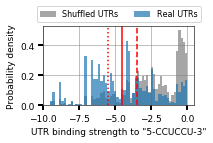

In [18]:
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)
ax.hist(strongest_fake, 60, normed=True, alpha=0.7, color='gray', label='Shuffled UTRs')
ax.hist(strongest_real, 60, normed=True, alpha=0.7, label='Real UTRs')
ax.axvline(-4.5, c='r')
ax.axvline(-3.5, c='r', linestyle='--')
ax.axvline(-5.5, c='r', linestyle=':')
ax.set_xlabel('UTR binding strength to "5-CCUCCU-3"')
ax.set_ylabel('Probability density')
fig.subplots_adjust(top=0.8, left=0.2, right=0.9, bottom=0.25)  # create some space below the plots by increasing the bottom-value
ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.15, 0.9, 0.7, 0.4), fontsize=8)
plt.savefig('../Results/Figures/SD_threshold.pdf')

# Actually dig into data to test for conservation of SD motifs
The below analysis is limited to ONLY 4-fold redundant codon sites that are within an aSD sequence binding site. Critically, for each one that I find, I compare the conservation at that site to the same synonymous codon or nucleotide context somewhere else in the same gene. With these paired lists, we can accurately compare whether there is any conservation differences while ruling out gene-specific effects.

## Positive control data. Find genes that have another gene directly 3' of them which are thus likely to contain a real SD sequence in their 3' terminus

In [19]:
preceding_genes = []
starts_positive_strand = []
starts_negative_strand = []
genome = list(SeqIO.parse('/Users/adamhockenberry/Projects/2017/Genome_database/Data/GBFs/511145.12.PATRIC.gbf', 'genbank'))
for record in genome:
    for feature in record.features:
        if feature.type == 'CDS':
            if feature.location.strand == 1:
                starts_positive_strand.append(feature.location.start)
            elif feature.location.strand == -1:
                starts_negative_strand.append(feature.location.end)
for i,j in enumerate(starts_positive_strand):
    starts_positive_strand[i] = list(range(j-20,j+20,1))
for i,j in enumerate(starts_negative_strand):
    starts_negative_strand[i] = list(range(j-20,j+20,1))
for record in genome:
    for feature in record.features:
        if feature.type == 'CDS':
            if feature.location.strand == 1:
                end = feature.location.end
                for i in starts_positive_strand:
                    if end in i:
                        preceding_genes.append(feature.qualifiers['locus_tag'][0])
            elif feature.location.strand == -1:
                end = feature.location.start
                for i in starts_negative_strand:
                    if end in i:
                        preceding_genes.append(feature.qualifiers['locus_tag'][0])
                        
preceding_genes = [i for i in seq_dicty[base_genome].keys() if i in preceding_genes]
not_preceding_genes = [i for i in seq_dicty[base_genome].keys() if i not in preceding_genes]
print(len(preceding_genes), len(not_preceding_genes), len(seq_dicty[base_genome].keys()))

391 1003 1394


In [20]:
three_prime_limitation_dict = {}
for gene_name, nts in seq_dicty[base_genome].items():
    three_prime_limitation_dict[gene_name] = list(range(len(nts)-50, len(nts)))

## Comparing conservation of a particular 4-fold redundant position that is within a strong binding sequence to a randomly chosen identical 4-fold redundant codon elsewhere in the sequence
Note I'm currently looking at a 6nt aSD sequence and only considering 4-fold redundant codons in positions 2,3,4, or 5. I'm also taking care not to double count any one position

In [21]:
def get_sd_sites(nt_sequence, asd_seq, threshold, fragment_energy_dict, position_limitation_list, upper_threshold=-20, min_position=100, max_position=-50):
    codon_list = [nt_sequence[nt:nt+3] for nt in range(0, len(nt_sequence), 3)]
    energy_list = []
    for i in range(0, len(nt_sequence)-len(asd_seq)):
        fragment = nt_sequence[i:i+len(asd_seq)]
        if fragment.count('-') == 0:
            energy = fragment_energy_dict[fragment.replace('T', 'U')]
            energy_list.append(energy)
        else:
            energy_list.append(np.nan)
    #######This gets all positions below the given threshold
    sd_positions_all_nts = [list(range(i, i+len(asd_seq))) for i,j in enumerate(energy_list) if j < threshold]
    sd_positions_all_nts = [item for sublist in sd_positions_all_nts for item in sublist]
    sd_positions_all_nts = list(set(sd_positions_all_nts))
    
    #######This gets all "start" position within the threshold range. Subtle but important difference
    if position_limitation_list != False:
        sd_positions_start = np.array([i for i,j in enumerate(energy_list) if upper_threshold < j and j < threshold and i in position_limitation_list])
    else:
        sd_positions_start = np.array([i for i,j in enumerate(energy_list) if upper_threshold < j and j < threshold and i > min_position and i < len(nt_sequence)+max_position])
    
    np.random.shuffle(sd_positions_start) #Shuffle this so that I'm not always analyzing the 5' ones every single time later on
    return sd_positions_all_nts, sd_positions_start, energy_list, codon_list

def get_control_sites_codon(nt_sequence, codon_list, sd_positions_all_nts, analyzed_positions, codon, min_position=100, max_position=-50):
    control_sites = [site*3+2 for site, x in enumerate(codon_list) if x == codon]
    control_sites = [site for site in control_sites if site > min_position and site < len(nt_sequence)+max_position]
    control_sites = [site for site in control_sites if site not in sd_positions_all_nts]
    control_sites = [site for site in control_sites if site not in analyzed_positions]
    return control_sites

def get_control_sites_tri_nt(nt_sequence, codon_list, sd_positions_all_nts, analyzed_positions, tri_nt, redundant_codons, min_position=100, max_position=-50):
    control_sites = [m.start()+1 for m in re.finditer(tri_nt, nt_sequence)]
    control_sites = [site for site in control_sites if site > min_position and site < len(nt_sequence)+max_position]
    control_sites = [site for site in control_sites if site%3 == 2]
    control_sites = [site for site in control_sites if nt_sequence[site-2:site+1] in redundant_codons]
    control_sites = [site for site in control_sites if site not in sd_positions_all_nts]
    control_sites = [site for site in control_sites if site not in analyzed_positions]
    return control_sites

def get_possible_energies(fragment, codon, all_codons, modifier, fragment_energy_dict):
    possible_energies = []
    for possible_codon in all_codons:
        if possible_codon != codon:
            if modifier == 2:
                possible_fragment = possible_codon + fragment[-3:]
            elif modifier == 3:
                possible_fragment = fragment[0] + possible_codon + fragment[-2:]
            elif modifier == 1:
                possible_fragment = possible_codon[-2:] + fragment[-4:]
            elif modifier == 4:
                possible_fragment = fragment[0:2] + possible_codon + fragment[-1]
            assert len(possible_fragment) == 6
            possible_energies.append(fragment_energy_dict[possible_fragment.replace('T', 'U')])
    return possible_energies


def paired_nt_analysis(dicty_to_analyze,\
                      genome_seq_dicty,\
                      fragment_energy_dict,\
                      asd_seq,\
                      conservation_dicty,\
                      nt_conservation_dicty,\
                      redundant_codons=redundant_codons,\
                      threshold=-4.5,\
                      upper_threshold=-20,\
                      min_position=100,\
                      max_position=-50,\
                      subset_names=False,\
                      only_conserved_aa=False,\
                      position_limitation_dict=False,\
                      internal_control='',\
                      nt_strength_restriction=''):
    '''
    This is my rather monsterous main function that has a lot of flags so be careful! 
    However, its complexity provides the benefit that I know all analyses are run through
    a common framework. For the most part, all of these flags are ultimately limiting the 
    data according to various criteria at different points in the pipeline.
    '''
    sds = []
    others = []
    analyzed_sd_dict = {}
    analyzed_control_dict = {}
    
    all_sds = []
    all_others = []
        
    for gene_name, seq in list(genome_seq_dicty.items())[:]:

        analyzed_sds = []
        analyzed_controls = []
        
        gene_sds = []
        gene_others = []
        
        ###########Skip ahead if this gene is not in my dictionary to analyze
        if gene_name not in dicty_to_analyze.keys():
            continue
        ###########Skip ahead if I want to only analyze a subset and this gene isn't in it
        if subset_names:
            if gene_name not in subset_names:
                continue
        ###########Hang on to this information for now to eventually limit where in the gene to consider, if relevant
        position_limitation_list = False
        if position_limitation_dict != False:
            position_limitation_list = position_limitation_dict[gene_name]
            
        ##################################################################################################
        ###GET LOCATIONS OF ALL SD-LIKE SEQUENCES THAT I MIGHT WANT TO ANALYZE FOR THIS GENE       
        sd_positions_all_nts, sd_positions_start, energy_list, codon_list =\
                        get_sd_sites(seq, asd_seq, threshold, fragment_energy_dict,\
                                     position_limitation_list=position_limitation_list,\
                                     upper_threshold=upper_threshold, min_position=min_position,\
                                     max_position=max_position)

        for i in sd_positions_start:
            energy = energy_list[i]
            modifiers = []
            if i%3 == 0:
                modifiers = [2]
            elif i%3 == 2:
                modifiers = [3]
            elif i%3 == 1:
                modifiers = [1,4]
            for modifier in modifiers:
                ##################################################################################################
                #If I'm only considering particular regions, make sure that this location is one of them
                if position_limitation_dict != False:
                    if i+modifier not in position_limitation_dict[gene_name]:
                        continue

                analyzed_positions = analyzed_sds + analyzed_controls
                
                ##################################################################################################
                #Make sure that the location is conserved, and if TRINT that the next position is conserved
                if only_conserved_aa == True:
                    if conservation_dicty[gene_name][int(np.floor((i+modifier)/3.))] != 'C':
                        continue
                if only_conserved_aa == True and internal_control=='TRINT':
                    if nt_conservation_dicty[gene_name][i+modifier+1] != 'C':
                        continue
                
                codon = seq[i+modifier-2:i+modifier+1]
                tri_nt = seq[i+modifier-1:i+modifier+2]
                if codon in redundant_codons:
                    ##################################################################################################
                    ###RUN A FILTER ACCORDING TO WHETHER I ONLY WANT TO SELECT STRONGEST OR WEAKEST POSSIBLE SEQUENCES
                    if nt_strength_restriction == 'None':
                        pass
                    else:
                        fragment = genome_seq_dicty[gene_name][i:i+len(asd_seq)]
                        all_codons = aa_to_codon_dict[codon_to_aa_dict[codon]]
                        all_codons = [temp for temp in all_codons if temp[:2] == codon[:2]]###Dealing with 6-fold redundant codons
                        possible_energies = get_possible_energies(fragment, codon, all_codons, modifier, fragment_energy_dict)
                        possible_energies = sorted(possible_energies)
                        assert len(possible_energies) == 3, possible_energies
                        if energy in possible_energies:###Because I don't know how to treat these cases
                            continue
                        insertion_point = bisect(possible_energies, energy)
                        #################################################################
                        ###Below will get rid of the ones that aren't included in my flag
                        if int(nt_strength_restriction) != insertion_point:
                            continue 
                            
                    ##################################################################################################
                    ###GET CONTROL SITES ACCORDING TO EITHER OF TWO DIFFERENT NULL MODELS
                    if internal_control == 'CODON':
                        control_sites =\
                            get_control_sites_codon(seq, codon_list, sd_positions_all_nts, analyzed_positions, codon,\
                                                   min_position=min_position, max_position=max_position)
                    elif internal_control == 'TRINT':
                        control_sites =\
                            get_control_sites_tri_nt(seq, codon_list, sd_positions_all_nts, analyzed_positions, tri_nt, redundant_codons,\
                                                    min_position=min_position, max_position=max_position)
                    else:
                        print("YOU DID NOT PROPERLY SPECIFY A CONTROL METHOD")
                        break
                    ##################################################################################################
                    ###Limit the controls based on conservation of the amino acid
                    if only_conserved_aa == True and internal_control == 'CODON':
                        control_sites = [site for site in control_sites if conservation_dicty[gene_name][int(np.floor(site/3.))] == 'C']
                    elif only_conserved_aa == True and internal_control == 'TRINT':
                        control_sites = [site for site in control_sites if conservation_dicty[gene_name][int(np.floor(site/3.))] == 'C']
                        control_sites = [site for site in control_sites if nt_conservation_dicty[gene_name][site+1] == 'C']

                    ##################################################################################################
                    ###IF ALL LOOKS WELL CHOOSE A CONTROL AND GO FORWARD WITH ANALYSIS
                    gene_sds.append(i+modifier)
                    gene_others.extend(control_sites)
                    if len(control_sites) > 0 and i+modifier not in analyzed_positions:
                        choice = random.choice(control_sites)
                        sds.append(dicty_to_analyze[gene_name][i+modifier])
                        others.append(dicty_to_analyze[gene_name][choice])
                        analyzed_sds.append(i+modifier)
                        analyzed_controls.append(choice)
                        #######################################################################
                        ###Fail safe to make sure I chose the right codons and context controls
                        if internal_control == 'CODON':
                            assert seq_dicty[base_genome][gene_name][i+modifier-2:i+modifier+1] == seq_dicty[base_genome][gene_name][choice-2:choice+1]
                        if internal_control == 'TRINT':
                            assert seq_dicty[base_genome][gene_name][i+modifier-1:i+modifier+2] == seq_dicty[base_genome][gene_name][choice-1:choice+2]
        gene_sds = list(set(gene_sds))
        gene_others = list(set(gene_others))
        
        all_sds.extend([dicty_to_analyze[gene_name][position] for position in gene_sds])
        all_others.extend([dicty_to_analyze[gene_name][position] for position in gene_others])
        analyzed_sd_dict[gene_name] = analyzed_sds
        analyzed_control_dict[gene_name] = analyzed_controls
    return sds, others, analyzed_sd_dict, analyzed_control_dict, all_sds, all_others

# Main function
There are a lot of flags but the analysis below is essentially the analysis that is used throughout the manuscript. Thresholds, null models, etc can all be altered below to accomplish various analyses that were depicted in the manuscript

In [24]:
dicty_to_analyze = dicty_hyphy #####If this changes, make sure to manually change file_name_modifiers
threshold=-4.5
upper_threshold=-20.
subset_names=preceding_genes
# subset_names=False
only_conserved_aa=True
position_limitation_dict=three_prime_limitation_dict
# position_limitation_dict=False
controls=('CODON', 'TRINT')
nt_strength_restriction='None'


mean_randomizations = 20
stat_randomizations = 20

#########################################################
####Putative aSD sequence to use in considering hybridization energies
with open('../Data/json-energyRef-CCUCCU.txt') as infile:
    fragment_energy_dict = json.load(infile)
asd_seq = 'CCUCCU'
#########################################################
#########################################################
#
#
#
#########################################################
####For writing files later
file_name_modifiers = '{}_{}_Threshold={}to{}_Conserved={}_NtRestriction={}'.format('hyphy', species_name, upper_threshold, threshold, only_conserved_aa, nt_strength_restriction)
if subset_names != False or position_limitation_dict != False:
    file_name_modifiers = file_name_modifiers + '_Subset=preceding_Position_limitation=3prime'
#########################################################
#########################################################
#
#
#########################################################
#These containers are for keeping track of randomizations to assess significance
actual_ratios_codon = []
shuffled_ratios_codon = {}
actual_ratios_trint = []
shuffled_ratios_trint = {}

for i in range(mean_randomizations):
    shuffled_ratios_codon[i] = []
    shuffled_ratios_trint[i] = []
    print('#####{}'.format(i))
    sds_codon, others_codon, analyzed_sd_dict, analyzed_ctrl_dict, all_sds_codon, all_others_codon = paired_nt_analysis(dicty_to_analyze,\
                                     seq_dicty[base_genome],\
                                     fragment_energy_dict,\
                                     asd_seq,\
                                     conservation_dicty,\
                                     nt_conservation_dicty,\
                                     threshold=threshold,\
                                     upper_threshold=upper_threshold,\
                                     subset_names=subset_names,\
                                     only_conserved_aa=only_conserved_aa,\
                                     position_limitation_dict=position_limitation_dict,\
                                     internal_control=controls[0],\
                                     nt_strength_restriction=nt_strength_restriction)
    actual_ratios_codon.append(np.mean(sds_codon)/np.mean(others_codon))
    print('Lengths:{}, {}, Means:{}, {}, Ratio:{}'.format(len(sds_codon), len(others_codon),\
                                                          np.mean(sds_codon), np.mean(others_codon),\
                                                          np.mean(sds_codon)/np.mean(others_codon)))
    diffs = np.array(sds_codon)-np.array(others_codon)
    print('Coin flip expt:', len([i for i in diffs if i > 0])/len([i for i in diffs if i != 0]))
    for j in range(stat_randomizations):
        combined = sds_codon + others_codon
        random.shuffle(combined)
        random_sds = combined[:len(sds_codon)]
        random_others = combined[len(sds_codon):]
        shuffled_ratios_codon[i].append(np.mean(random_sds)/np.mean(random_others))
        
        
    sds_trint, others_trint, analyzed_sd_dict, analyzed_ctrl_dict, all_sds_trint, all_others_trint = paired_nt_analysis(dicty_to_analyze,\
                                     seq_dicty[base_genome],\
                                     fragment_energy_dict,\
                                     asd_seq,\
                                     conservation_dicty,\
                                     nt_conservation_dicty,\
                                     threshold=threshold,\
                                     upper_threshold=upper_threshold,\
                                     subset_names=subset_names,\
                                     only_conserved_aa=only_conserved_aa,\
                                     position_limitation_dict=position_limitation_dict,\
                                     internal_control=controls[1],\
                                     nt_strength_restriction=nt_strength_restriction)
    actual_ratios_trint.append(np.mean(sds_trint)/np.mean(others_trint))
    print('Lengths:{}, {}, Means:{}, {}, Ratio:{}'.format(len(sds_trint), len(others_trint),\
                                                          np.mean(sds_trint), np.mean(others_trint),\
                                                          np.mean(sds_trint)/np.mean(others_trint)))
    diffs = np.array(sds_trint)-np.array(others_trint)
    print('Coin flip expt:', len([i for i in diffs if i > 0])/len([i for i in diffs if i != 0]))
    for j in range(stat_randomizations):
        combined = sds_trint + others_trint
        random.shuffle(combined)
        random_sds = combined[:len(sds_trint)]
        random_others = combined[len(sds_trint):]
        shuffled_ratios_trint[i].append(np.mean(random_sds)/np.mean(random_others))

#####0
Lengths:31, 31, Means:1.0224528873501033, 2.9728406158325256, Ratio:0.3439312830646899
Coin flip expt: 0.1935483870967742
Lengths:15, 15, Means:0.9059830708518377, 3.1022163826029683, Ratio:0.29204380324097734
Coin flip expt: 0.13333333333333333
#####1
Lengths:31, 31, Means:1.0224528873501033, 2.7008901069112174, Ratio:0.3785614545122672
Coin flip expt: 0.25806451612903225
Lengths:15, 15, Means:0.9059830708518377, 3.2745313721685383, Ratio:0.2766756423688975
Coin flip expt: 0.13333333333333333
#####2
Lengths:31, 31, Means:1.0224528873501033, 3.2360298388181548, Ratio:0.3159590418744464
Coin flip expt: 0.22580645161290322
Lengths:15, 15, Means:0.9059830708518377, 3.238801893780632, Ratio:0.2797278439881019
Coin flip expt: 0.2
#####3
Lengths:31, 31, Means:1.0224528873501033, 3.071263251123932, Ratio:0.3329095566705119
Coin flip expt: 0.12903225806451613
Lengths:15, 15, Means:0.9059830708518377, 3.401088073683417, Ratio:0.26638036158547573
Coin flip expt: 0.06666666666666667
#####4

In [25]:
dfA = pd.DataFrame({'Actual_rats_codon':actual_ratios_codon})
dfB = pd.DataFrame({'Shuffled_rats_codon':[j[0] for i,j in shuffled_ratios_codon.items()]})
dfC = pd.DataFrame({'Actual_rats_trint':actual_ratios_trint})
dfD = pd.DataFrame({'Shuffled_rats_trint':[j[0] for i,j in shuffled_ratios_trint.items()]})
df = pd.concat([dfA[['Actual_rats_codon']],dfB[['Shuffled_rats_codon']],\
               dfC[['Actual_rats_trint']],dfD[['Shuffled_rats_trint']]], axis=1)
df['N_(codon)'] = len(sds_codon)
df['N_(trint)'] = len(sds_trint)
df.to_csv('../Results/Dataframes/df_{}_ratios.csv'.format(file_name_modifiers), index=False)


dfA = pd.DataFrame({'SD-like(codon)':all_sds_codon})
dfB = pd.DataFrame({'SD-like(trint)':all_sds_trint})
dfC = pd.DataFrame({'Control\n(codon)':all_others_codon})
dfD = pd.DataFrame({'Control\n(context)':all_others_trint})
df = pd.concat([dfA[['SD-like(codon)']],dfB[['SD-like(trint)']], dfC[['Control\n(codon)']], dfD[['Control\n(context)']]], axis=1)
df.to_csv('../Results/Dataframes/df_{}_all.csv'.format(file_name_modifiers), index=False)

dist_of_codon_means = []
for j in range(stat_randomizations):
    temp = []
    for i in range(mean_randomizations):
        temp.append(shuffled_ratios_codon[i][j])
    dist_of_codon_means.append(np.mean(temp))

dist_of_trint_means = []
for j in range(stat_randomizations):
    temp = []
    for i in range(mean_randomizations):
        temp.append(shuffled_ratios_trint[i][j])
    dist_of_trint_means.append(np.mean(temp))
    
dfA = pd.DataFrame({'Names':['Actual']+list(range(len(dist_of_codon_means)))})
dfB = pd.DataFrame({'Values(codon)':[np.mean(actual_ratios_codon)]+dist_of_codon_means})
dfC = pd.DataFrame({'Values(trint)':[np.mean(actual_ratios_trint)]+dist_of_trint_means})
df = pd.concat([dfA[['Names']],dfB[['Values(codon)']], dfC[['Values(trint)']]], axis=1)
df.to_csv('../Results/Dataframes/df_{}_stat_sig.csv'.format(file_name_modifiers), index=False)

In [ ]:
###Saved this data to make prettier figures but because I'm ants-y and want to see how they look
plt.figure()
plt.hist(dist_of_trint_means)
plt.axvline(np.mean(actual_ratios_trint), c='r')

plt.figure()
plt.hist(dist_of_codon_means)
plt.axvline(np.mean(actual_ratios_codon), c='r')

# Put rates into context
Similar paired analysis of 2-fold vs 4-fold redundant codons

In [ ]:
genome_seq_dicty = seq_dicty[base_genome]
dicty_to_analyze = dicty_hyphy

ratios_all = []
for randomization in range(3):
    two_fold = []
    four_fold = []
    two_fold_all = []
    four_fold_all = []
    for gene_name, nt_sequence in list(genome_seq_dicty.items())[:]:
        if gene_name not in dicty_to_analyze.keys():
            continue
        two_fold_gene = []
        four_fold_gene = []
        codon_list = [nt_sequence[nt:nt+3] for nt in range(0, len(nt_sequence), 3)]
        for i, codon in enumerate(codon_list):
            if codon == '---':
                continue
            if i < 33:
                continue
            if i > len(codon_list)-16:
                continue
            if conservation_dicty[gene_name][i] != 'C':
                continue
            if codon in redundant_codons:
                four_fold_gene.append(dicty_to_analyze[gene_name][i*3+2])
            elif codon_to_aa_dict[codon] in ['F', 'D', 'E', 'K', 'N', 'Q', 'H', 'Y', 'C']:
                two_fold_gene.append(dicty_to_analyze[gene_name][i*3+2])
        smallest_set = min([len(two_fold_gene), len(four_fold_gene)])
        two_fold_truncated = random.sample(two_fold_gene, smallest_set)
        four_fold_truncated = random.sample(four_fold_gene, smallest_set)
        two_fold.extend(two_fold_truncated)
        four_fold.extend(four_fold_truncated)
        two_fold_all.extend(two_fold_gene)
        four_fold_all.extend(four_fold_gene)
    ratio_i = np.mean(four_fold)/np.mean(two_fold)
    ratios_all.append(ratio_i)
    print(randomization, ratio_i, len(four_fold), len(two_fold), len(two_fold_all), len(four_fold_all))
print(np.mean(four_fold_all)/np.mean(two_fold_all))

In [ ]:
plt.figure()
plt.boxplot([two_fold, four_fold]);
plt.ylim(0,10)

# Protein Domain analysis

In [ ]:
df = pd.read_csv('../Data/foldingFromPNAS_v2.csv')
df['bNumber'] = ''
df['patricNumber'] = ''
print(len(df.index))

for index in df.index:
    names = df.loc[index]['Gene names'].split(' ')
    for name in names:
        if name in reference_name_dict.keys():
            df.set_value(index, 'bNumber', name)
            try:
                df.set_value(index, 'patricNumber', reference_name_dict[name])
            except KeyError:
                pass

df = df[df['patricNumber'] != '']
print(len(df.index))

### Choose whether to stratify the data according to Lm
A lot of degrees of potential degrees of freedom here which can be dangerous. Be rational.

In [ ]:
df = df[df['Lm (residues)'].isnull() == False]
# df = df[(df['Lm (residues)'] > 0) & (df['Lm (residues)'] <= 50)]

### `domain_dict` will specify what regions in what proteins I want to actually consider 

In [ ]:
df['Domain_beg_nt'] = int()
df['Domain_end_nt'] = int()
for index in df.index:
    domain_beg, domain_end = df.loc[index]['Codon range of domain'].split('-')
    df.set_value(index, 'Domain_beg_nt', int(domain_beg)*3)
    df.set_value(index, 'Domain_end_nt', int(domain_end)*3)


df['Domain_beg_in_patric'] = int()
df['Domain_end_in_patric'] = int()
for index in df.index:    
    ref_seq_beg = ref_genome_seq_ref_dict[df.loc[index]['bNumber']][int(df.loc[index]['Domain_beg_nt']):int(df.loc[index]['Domain_beg_nt'])+100]
    ref_seq_end = ref_genome_seq_ref_dict[df.loc[index]['bNumber']][int(df.loc[index]['Domain_end_nt'])-100:int(df.loc[index]['Domain_end_nt'])]
    df.set_value(index, 'Domain_beg_in_patric', ref_genome_seq_patric_dict[df.loc[index]['patricNumber']].find(ref_seq_beg))
    df.set_value(index, 'Domain_end_in_patric', ref_genome_seq_patric_dict[df.loc[index]['patricNumber']].find(ref_seq_end) + 100)




###Inside of domains
domain_dict = {}
for index in df.index:
    if df.loc[index]['Domain_beg_in_patric'] > 100:
        try:
            domain_dict[df.loc[index]['patricNumber']].extend(list(range(df.loc[index]['Domain_beg_in_patric'], df.loc[index]['Domain_end_in_patric'])))
        except:
            domain_dict[df.loc[index]['patricNumber']] = list(range(df.loc[index]['Domain_beg_in_patric'], df.loc[index]['Domain_end_in_patric']))
    else:
        if df.loc[index]['Domain_end_in_patric'] < 100:
            pass
        else:
            try:
                domain_dict[df.loc[index]['patricNumber']].extend(list(range(100, df.loc[index]['Domain_end_in_patric'])))
            except:
                domain_dict[df.loc[index]['patricNumber']] = list(range(100, df.loc[index]['Domain_end_in_patric']))

to_delete = []        
for gene_name in domain_dict.keys():
    if gene_name not in dicty_to_analyze.keys():
        to_delete.append(gene_name)
for gene_name in to_delete:
    del domain_dict[gene_name]
print('Inside domains: {}'.format(len(domain_dict.keys())))


###Post domain dicts
post_domain_dict = {}
for index in df.index:
    try:
        post_domain_dict[df.loc[index]['patricNumber']].append(df.loc[index]['Domain_end_in_patric'])
    except:
        post_domain_dict[df.loc[index]['patricNumber']] = [df.loc[index]['Domain_end_in_patric']]
        
to_delete = []        
for gene_name in post_domain_dict.keys():
    if gene_name not in dicty_to_analyze.keys():
        to_delete.append(gene_name)
for gene_name in to_delete:
    del post_domain_dict[gene_name]

for i,j in post_domain_dict.items():
    tempy = []
    for loc in j:
        if loc+150 > len(seq_dicty[base_genome][i])-50:
            if loc+30 > len(seq_dicty[base_genome][i]):
                pass
            else:
                tempy.extend(list(range(loc+30, len(seq_dicty[base_genome][i])-50))) #####IMPORTANT
        else:
            tempy.extend(list(range(loc+30, loc+150))) #####IMPORTANT
    post_domain_dict[i] = tempy
print('Post domains: {}'.format(len(post_domain_dict.keys())))

# Copy and pasted code above, just making a few changes to initial parameters

In [ ]:
dicty_to_analyze = dicty_hyphy #####If this changes, make sure to manually change file_name_modifiers
threshold=-4.5
upper_threshold=-20
# subset_names=domain_dict.keys()#####CRITICAL
subset_names=post_domain_dict.keys()#####CRITICAL
only_conserved_aa=True
# position_limitation_dict=domain_dict####CRITICAL
position_limitation_dict=post_domain_dict####CRITICAL
controls=('CODON', 'TRINT')
nt_strength_restriction='3'

#########################################################
####Putative aSD sequence to use in considering hybridization energies
with open('../Data/json-energyRef-CCUCCU.txt') as infile:
    fragment_energy_dict = json.load(infile)
asd_seq = 'CCUCCU'


actual_ratios_codon = []
shuffled_ratios_codon = []
actual_ratios_trint = []
shuffled_ratios_trint = []
for i in range(20):
    print('#####{}'.format(i))
    sds, others, analyzed_sd_dict, analyzed_ctrl_dict = paired_nt_analysis(dicty_to_analyze,\
                                     seq_dicty[base_genome],\
                                     fragment_energy_dict,\
                                     asd_seq,\
                                     conservation_dicty,\
                                     nt_conservation_dicty,\
                                     threshold=threshold,\
                                     upper_threshold=upper_threshold,\
                                     randomization=False,\
                                     subset_names=subset_names,\
                                     only_conserved_aa=only_conserved_aa,\
                                     position_limitation_dict=position_limitation_dict,\
                                     internal_control=controls[0],\
                                     nt_strength_restriction=nt_strength_restriction)
    actual_ratios_codon.append(np.mean(sds)/np.mean(others))
    print('Lengths:{}, {}, Means:{}, {}, Ratio:{}'.format(len(sds), len(others), np.mean(sds), np.mean(others), np.mean(sds)/np.mean(others)))
    sds, others, analyzed_sd_dict, analyzed_ctrl_dict = paired_nt_analysis(dicty_to_analyze,\
                                     seq_dicty[base_genome],\
                                     fragment_energy_dict,\
                                     asd_seq,\
                                     conservation_dicty,\
                                     nt_conservation_dicty,\
                                     threshold=threshold,\
                                     upper_threshold=upper_threshold,\
                                     randomization=True,\
                                     subset_names=subset_names,\
                                     only_conserved_aa=only_conserved_aa,\
                                     position_limitation_dict=position_limitation_dict,\
                                     internal_control=controls[0],\
                                     nt_strength_restriction=nt_strength_restriction)
    shuffled_ratios_codon.append(np.mean(sds)/np.mean(others))
    
    sds, others, analyzed_sd_dict, analyzed_ctrl_dict = paired_nt_analysis(dicty_to_analyze,\
                                     seq_dicty[base_genome],\
                                     fragment_energy_dict,\
                                     asd_seq,\
                                     conservation_dicty,\
                                     nt_conservation_dicty,\
                                     threshold=threshold,\
                                     upper_threshold=upper_threshold,\
                                     randomization=False,\
                                     subset_names=subset_names,\
                                     only_conserved_aa=only_conserved_aa,\
                                     position_limitation_dict=position_limitation_dict,\
                                     internal_control=controls[1],\
                                     nt_strength_restriction=nt_strength_restriction)
    actual_ratios_trint.append(np.mean(sds)/np.mean(others))
    print('Lengths:{}, {}, Means:{}, {}, Ratio:{}'.format(len(sds), len(others), np.mean(sds), np.mean(others), np.mean(sds)/np.mean(others)))
    sds, others, analyzed_sd_dict, analyzed_ctrl_dict = paired_nt_analysis(dicty_to_analyze,\
                                     seq_dicty[base_genome],\
                                     fragment_energy_dict,\
                                     asd_seq,\
                                     conservation_dicty,\
                                     nt_conservation_dicty,\
                                     threshold=threshold,\
                                     upper_threshold=upper_threshold,\
                                     randomization=True,\
                                     subset_names=subset_names,\
                                     only_conserved_aa=only_conserved_aa,\
                                     position_limitation_dict=position_limitation_dict,\
                                     internal_control=controls[1],\
                                     nt_strength_restriction=nt_strength_restriction)
    shuffled_ratios_trint.append(np.mean(sds)/np.mean(others))

In [ ]:
if position_limitation_dict == domain_dict:
    dfA = pd.DataFrame({'Actual_rats_codon_domain':actual_ratios_codon})
    dfB = pd.DataFrame({'Actual_rats_trint_domain':actual_ratios_trint})
elif position_limitation_dict == post_domain_dict:
    dfC = pd.DataFrame({'Actual_rats_codon_post_domain':actual_ratios_codon})
    dfD = pd.DataFrame({'Actual_rats_trint_post_domain':actual_ratios_trint})
else:
    print('Go back and change something!')

In [ ]:
df = pd.concat([dfA[['Actual_rats_codon_domain']],dfB[['Actual_rats_trint_domain']],\
               dfC[['Actual_rats_codon_post_domain']],dfD[['Actual_rats_trint_post_domain']]], axis=1)
df.to_csv('../Results/temp_df_domain_analysis_cotrans_NTrestriction={}_ratios.csv'.format(nt_strength_restriction), index=False)

# Testing gene expression differences systematically

### First, tediously get a dictionary linking names in PATRIC annotations to names in RefSeq

In [ ]:
genome_ref = list(SeqIO.parse('/Users/adamhockenberry/Projects/2017/Genome_database/Data/GBFs/511145.12.RefSeq.gbf', 'genbank'))[0]
genome_pat = list(SeqIO.parse('/Users/adamhockenberry/Projects/2017/Genome_database/Data/GBFs/511145.12.PATRIC.gbf', 'genbank'))[0]

locs_dict_ref_positive = {}
locs_dict_ref_negative = {}

locs_dict_pat_positive = {}
locs_dict_pat_negative = {}

ref_genome_seq_ref_dict = {}
ref_genome_seq_patric_dict = {}

for feature_pat in genome_pat.features[:]:
    if feature_pat.type == 'CDS':
        name_pat = feature_pat.qualifiers['locus_tag'][0]
        strand_pat = feature_pat.strand
        if strand_pat == 1:
            locs_dict_pat_positive[name_pat] = list(range(feature_pat.location.start, feature_pat.location.end))
            ref_genome_seq_patric_dict[name_pat] = genome_pat.seq[feature_pat.location.start:feature_pat.location.end]
        elif strand_pat == -1:
            locs_dict_pat_negative[name_pat] = list(range(feature_pat.location.start, feature_pat.location.end))
            ref_genome_seq_patric_dict[name_pat] = genome_pat.seq[feature_pat.location.start:feature_pat.location.end].reverse_complement()

for feature_ref in genome_ref.features[:]:
    if feature_ref.type == 'CDS':
        name_ref = feature_ref.qualifiers['locus_tag'][0]
        strand_ref = feature_ref.strand
        if strand_ref == 1:
            locs_dict_ref_positive[name_ref] = list(range(feature_ref.location.start, feature_ref.location.end))
            ref_genome_seq_ref_dict[name_ref] = genome_ref.seq[feature_ref.location.start:feature_ref.location.end]

        elif strand_ref == -1:
            locs_dict_ref_negative[name_ref] = list(range(feature_ref.location.start, feature_ref.location.end))
            ref_genome_seq_ref_dict[name_ref] = genome_ref.seq[feature_ref.location.start:feature_ref.location.end].reverse_complement()
            
print(len(locs_dict_pat_positive.keys()))
print(len(locs_dict_pat_negative.keys()))
print(len(locs_dict_ref_positive.keys()))
print(len(locs_dict_ref_negative.keys()))   

reference_name_dict = {}
for name_pat, loc_pat in sorted(locs_dict_pat_positive.items()):
    for name_ref, loc_ref in sorted(locs_dict_ref_positive.items()):
        if len(set(loc_pat)&set(loc_ref)) / len(loc_pat) > 0.9:
            reference_name_dict[name_ref] = name_pat
            del locs_dict_ref_positive[name_ref]
            break
            
for name_pat, loc_pat in sorted(locs_dict_pat_negative.items()):
    for name_ref, loc_ref in sorted(locs_dict_ref_negative.items()):
        if len(set(loc_pat)&set(loc_ref)) / len(loc_pat) > 0.9:
            reference_name_dict[name_ref] = name_pat
            del locs_dict_ref_negative[name_ref]
            break
print(len(reference_name_dict.keys()), len(ref_genome_seq_patric_dict.keys()), len(ref_genome_seq_ref_dict.keys()))

### Load in dataset of protein abundance from PaxDB (integrated dataset)

In [ ]:
df = pd.read_csv('/Users/adamhockenberry/Downloads/511145/511145-WHOLE_ORGANISM-integrated.txt',\
                 index_col = 'string_external_id', sep='\t', skiprows=10)
expression_dict = {}
for index in df.index:
    temp_name = index.split('.')[-1]
    try:
        expression_dict[reference_name_dict[temp_name]] = df.loc[index]['abundance']
    except KeyError:
        pass

### Get list of gene expression values in my dataset

In [ ]:
dict_to_analyze = dicty_hyphy

full_listy = []
for key in expression_dict.keys():
    if key in dict_to_analyze.keys():
        full_listy.append(expression_dict[key])
print(len(full_listy))
full_listy_to_plot = sorted(full_listy)[:-1]

In [ ]:
percentile_20 = np.percentile(full_listy, 20)
percentile_40 = np.percentile(full_listy, 40)
percentile_60 = np.percentile(full_listy, 60)
percentile_80 = np.percentile(full_listy, 80)

expression_quantile_dict = {}
expression_quantile_dict['lowest'] = []
expression_quantile_dict['low'] = []
expression_quantile_dict['mid'] = []
expression_quantile_dict['high'] = []
expression_quantile_dict['highest'] = []

for seq_name in dict_to_analyze:
    if seq_name not in expression_dict.keys():
        continue
    if expression_dict[seq_name] < percentile_20:
        expression_quantile_dict['lowest'].append(seq_name)
    elif expression_dict[seq_name] >= percentile_20 and expression_dict[seq_name] < percentile_40:
        expression_quantile_dict['low'].append(seq_name)
    elif expression_dict[seq_name] >= percentile_40 and expression_dict[seq_name] < percentile_60:
        expression_quantile_dict['mid'].append(seq_name)
    elif expression_dict[seq_name] >= percentile_60 and expression_dict[seq_name] < percentile_80:
        expression_quantile_dict['high'].append(seq_name)
    elif expression_dict[seq_name] >= percentile_80 :
        expression_quantile_dict['highest'].append(seq_name)
    
for key, vals in expression_quantile_dict.items():
    print(key, len(vals))


# Visualize some differences between the categories

In [ ]:
fig, ax = plt.subplots(figsize=(5,2))
ax.hist(full_listy_to_plot, 10000, cumulative=True, histtype='step')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.axvspan(percentile_20, percentile_40, color='k', alpha=0.2)
ax.axvspan(percentile_60, percentile_80, color='k', alpha=0.2)
ax.set_xlabel('Protein abundance')
ax.set_ylabel('Cumulative\ncounts')
plt.tight_layout()


In [ ]:
asd_seq = 'CCUCCU'
threshold = -4.5
upper_threshold = -20

density_dict = {}
eligible_density_dict = {}
exp_energy_dict = {}
basic_conservation_dict = {}
for category in ['lowest', 'low', 'mid', 'high', 'highest'][:]:
    lengths = []
    sd_nts = []
    energies_temp = []
    cons = []
    eligible_sites = []
    
    for gene_name in expression_quantile_dict[category]:
        if gene_name in seq_dicty[base_genome].keys():
            seq = seq_dicty[base_genome][gene_name]
            sd_positions_all_nts, sd_positions_start, energy_list, codon_list =\
                get_sd_sites(seq, asd_seq, threshold, fragment_energy_dict,\
                             position_limitation_list=False, upper_threshold=upper_threshold)
            sd_nts.append(len(sd_positions_all_nts))
            lengths.append(len(seq)-150)
            energies_temp.extend([i for i in energy_list if i < threshold])
            cons.append(conservation_dicty[gene_name].count('C')/len(conservation_dicty[gene_name]))
            
            eligible_sites_ind = []
            for i in sd_positions_start:
                modifiers = []
                if i%3 == 0:
                    modifiers = [2]
                elif i%3 == 2:
                    modifiers = [3]
                elif i%3 == 1:
                    modifiers = [1,4]
                for modifier in modifiers:
                    if conservation_dicty[gene_name][int(np.floor((i+modifier)/3.))] != 'C':
                        continue
                    codon = seq[i+modifier-2:i+modifier+1]
                    if codon in redundant_codons:
                        eligible_sites_ind.append(i+modifier)
                        
            eligible_sites_ind = list(set(eligible_sites_ind))
            eligible_sites.append(len(eligible_sites_ind))
            
            
            
    density_dict[category] = np.array(sd_nts)/np.array(lengths)
    exp_energy_dict[category] = energies_temp
    basic_conservation_dict[category] = cons
    eligible_density_dict[category] = np.array(eligible_sites)/np.array(lengths)

In [ ]:
fig = plt.figure(figsize=(3.5,3.5))
ax = fig.add_subplot(311)
boxes = ax.bar([0, 1, 2, 3, 4], [np.mean(density_dict[i]) for i in ['lowest', 'low', 'mid', 'high', 'highest']], facecolor='0.3')
# ax.set_ylim(-0.01, 0.18)

ax.set_xticklabels('')
ax.set_ylabel('SD-like nt\nfraction')

for line in ax.xaxis.get_ticklines():
    line.set_markersize(0)
    line.set_markeredgewidth(0)

ax = fig.add_subplot(312)
boxes = ax.bar([0, 1, 2, 3, 4], [np.mean(basic_conservation_dict[i]) for i in ['lowest', 'low', 'mid', 'high', 'highest']], facecolor='0.3')
# ax.set_ylim(-0.01, 0.18)
ax.set_xticklabels('')
ax.set_ylabel('Conserved AA\nfraction')
for line in ax.xaxis.get_ticklines():
    line.set_markersize(0)
    line.set_markeredgewidth(0)

ax = fig.add_subplot(313)
boxes = ax.bar([0, 1, 2, 3, 4], [np.mean(eligible_density_dict[i]) for i in ['lowest', 'low', 'mid', 'high', 'highest']], facecolor='0.3')
ax.set_xticklabels('')
ax.set_ylabel('Eligible SD-like\nnt fraction')
ax.set_xticklabels(['', 'Lowest 20%', '', '', '', 'Highest 20%'], ha='center')
ax.set_xlabel('Gene expression bins')
plt.tight_layout(h_pad=-0.1)
plt.savefig('../Results/Figures/expression_summary.pdf')

In [ ]:
#####Parameters!
dicty_to_analyze = dicty_hyphy
threshold=-4.5
upper_threshold=-20
only_conserved_aa=True
position_limitation_dict=False
controls=('CODON', 'TRINT')
nt_strength_restriction='None'

meta_codon = []
meta_trint = []
for cat in ['lowest', 'low', 'mid', 'high', 'highest']:
    file_name_modifiers = '{}_{}_Threshold={}to{}_Conserved={}_NtRestriction={}_Subset={}'.format('hyphy', species_name, upper_threshold, threshold, only_conserved_aa, nt_strength_restriction, cat)
    print('#####{}'.format(cat))
    subset_names = expression_quantile_dict[cat]
    actual_ratios_codon = []
    shuffled_ratios_codon = {}
    actual_ratios_trint = []
    shuffled_ratios_trint = {}
    for i in range(20):
        shuffled_ratios_codon[i] = []
        shuffled_ratios_trint[i] = []
        print('#####{}'.format(i))
        sds_codon, others_codon, analyzed_sd_dict, analyzed_ctrl_dict, all_sds_codon, all_others_codon = paired_nt_analysis(dicty_to_analyze,\
                                         seq_dicty[base_genome],\
                                         fragment_energy_dict,\
                                         asd_seq,\
                                         conservation_dicty,\
                                         nt_conservation_dicty,\
                                         threshold=threshold,\
                                         upper_threshold=upper_threshold,\
                                         subset_names=subset_names,\
                                         only_conserved_aa=only_conserved_aa,\
                                         position_limitation_dict=position_limitation_dict,\
                                         internal_control=controls[0],\
                                         nt_strength_restriction=nt_strength_restriction)
        actual_ratios_codon.append(np.mean(sds_codon)/np.mean(others_codon))
        print('Lengths:{}, {}, Means:{}, {}, Ratio:{}'.format(len(sds_codon), len(others_codon),\
                                                              np.mean(sds_codon), np.mean(others_codon),\
                                                              np.mean(sds_codon)/np.mean(others_codon)))
        diffs = np.array(sds_codon)-np.array(others_codon)
        print('Coin flip expt:', len([i for i in diffs if i > 0])/len([i for i in diffs if i != 0]))
        for j in range(stat_randomizations):
            combined = sds_codon + others_codon
            random.shuffle(combined)
            random_sds = combined[:len(sds_codon)]
            random_others = combined[len(sds_codon):]
            shuffled_ratios_codon[i].append(np.mean(random_sds)/np.mean(random_others))


        sds_trint, others_trint, analyzed_sd_dict, analyzed_ctrl_dict, all_sds_trint, all_others_trint = paired_nt_analysis(dicty_to_analyze,\
                                         seq_dicty[base_genome],\
                                         fragment_energy_dict,\
                                         asd_seq,\
                                         conservation_dicty,\
                                         nt_conservation_dicty,\
                                         threshold=threshold,\
                                         upper_threshold=upper_threshold,\
                                         subset_names=subset_names,\
                                         only_conserved_aa=only_conserved_aa,\
                                         position_limitation_dict=position_limitation_dict,\
                                         internal_control=controls[1],\
                                         nt_strength_restriction=nt_strength_restriction)
        actual_ratios_trint.append(np.mean(sds_trint)/np.mean(others_trint))
        print('Lengths:{}, {}, Means:{}, {}, Ratio:{}'.format(len(sds_trint), len(others_trint),\
                                                              np.mean(sds_trint), np.mean(others_trint),\
                                                              np.mean(sds_trint)/np.mean(others_trint)))
        diffs = np.array(sds_trint)-np.array(others_trint)
        print('Coin flip expt:', len([i for i in diffs if i > 0])/len([i for i in diffs if i != 0]))
        for j in range(stat_randomizations):
            combined = sds_trint + others_trint
            random.shuffle(combined)
            random_sds = combined[:len(sds_trint)]
            random_others = combined[len(sds_trint):]
            shuffled_ratios_trint[i].append(np.mean(random_sds)/np.mean(random_others))
    
    
    dfA = pd.DataFrame({'Actual_rats_codon':actual_ratios_codon})
    dfB = pd.DataFrame({'Shuffled_rats_codon':[j[0] for i,j in shuffled_ratios_codon.items()]})
    dfC = pd.DataFrame({'Actual_rats_trint':actual_ratios_trint})
    dfD = pd.DataFrame({'Shuffled_rats_trint':[j[0] for i,j in shuffled_ratios_trint.items()]})
    df = pd.concat([dfA[['Actual_rats_codon']],dfB[['Shuffled_rats_codon']],\
                   dfC[['Actual_rats_trint']],dfD[['Shuffled_rats_trint']]], axis=1)
    df['N_(codon)'] = len(sds_codon)
    df['N_(trint)'] = len(sds_trint)
    df.to_csv('../Results/Dataframes/df_{}_ratios.csv'.format(file_name_modifiers), index=False)


    dfA = pd.DataFrame({'SD-like(codon)':all_sds_codon})
    dfB = pd.DataFrame({'SD-like(trint)':all_sds_trint})
    dfC = pd.DataFrame({'Control\n(codon)':all_others_codon})
    dfD = pd.DataFrame({'Control\n(context)':all_others_trint})
    df = pd.concat([dfA[['SD-like(codon)']],dfB[['SD-like(trint)']], dfC[['Control\n(codon)']], dfD[['Control\n(context)']]], axis=1)
    df.to_csv('../Results/Dataframes/df_{}_all.csv'.format(file_name_modifiers), index=False)

    dist_of_codon_means = []
    for j in range(stat_randomizations):
        temp = []
        for i in range(mean_randomizations):
            temp.append(shuffled_ratios_codon[i][j])
        dist_of_codon_means.append(np.mean(temp))

    dist_of_trint_means = []
    for j in range(stat_randomizations):
        temp = []
        for i in range(mean_randomizations):
            temp.append(shuffled_ratios_trint[i][j])
        dist_of_trint_means.append(np.mean(temp))

    dfA = pd.DataFrame({'Names':['Actual']+list(range(len(dist_of_codon_means)))})
    dfB = pd.DataFrame({'Values(codon)':[np.mean(actual_ratios_codon)]+dist_of_codon_means})
    dfC = pd.DataFrame({'Values(trint)':[np.mean(actual_ratios_trint)]+dist_of_trint_means})
    df = pd.concat([dfA[['Names']],dfB[['Values(codon)']], dfC[['Values(trint)']]], axis=1)
    df.to_csv('../Results/Dataframes/df_{}_stat_sig.csv'.format(file_name_modifiers), index=False)

    
    
    meta_codon.append(actual_ratios_codon)
    meta_trint.append(actual_ratios_trint)
    print(len(sds_codon), np.mean(actual_ratios_codon), np.mean(actual_ratios_trint))

In [ ]:
plt.figure()
plt.violinplot(meta_codon, showextrema=False)


plt.figure()
plt.violinplot(meta_trint, showextrema=False)

# DEPRECATED CODE THAT I'D LIKE TO HANG ON TO

In [ ]:
dicty_to_analyze = dicty_hyphy
threshold=-4.5
upper_threshold=-20
subset_names=False
only_conserved_aa=True
three_prime_analysis=False
controls=('CODON', 'TRINT')
# nt_strength_restriction=''
nt_strength_restriction='CURRENT_IS_WEAKEST'

#########################################################
####Putative aSD sequence to use in considering hybridization energies
with open('../Data/json-energyRef-CCUCCU.txt') as infile:
    fragment_energy_dict = json.load(infile)
asd_seq = 'CCUCCU'


x_sds_all = []
x_controls_all=[]
for i in range(2):
    sds, others, analyzed_sd_dict, analyzed_ctrl_dict = paired_nt_analysis(dicty_to_analyze,\
                                     seq_dicty[base_genome],\
                                     fragment_energy_dict,\
                                     asd_seq,\
                                     conservation_dicty,\
                                     threshold=threshold,\
                                     upper_threshold=upper_threshold,\
                                     randomization=False,\
                                     subset_names=subset_names,\
                                     only_conserved_aa=only_conserved_aa,\
                                     three_prime_analysis=three_prime_analysis,\
                                     internal_control=controls[0],\
                                     nt_strength_restriction=nt_strength_restriction)
    print(len(sds), len(others))
    nts_sds = []
    nts_controls = []
    for gene_name, positions in analyzed_sd_dict.items():
        for i in positions:
            ec_nt = seq_dicty[base_genome][gene_name][i]
            matches = []
            for genome in ordered_names:
                if seq_dicty[genome][gene_name][i] == ec_nt:
                    matches.append(1)
                else:
                    matches.append(0)
            nts_sds.append(matches)

    for gene_name, positions in analyzed_ctrl_dict.items():
        for i in positions:
            ec_nt = seq_dicty[base_genome][gene_name][i]
            matches = []
            for genome in ordered_names:
                if seq_dicty[genome][gene_name][i] == ec_nt:
                    matches.append(1)
                else:
                    matches.append(0)
            nts_controls.append(matches)
    nts_sds = nts_sds * np.exp(np.linspace(10, 1, 61))
    nts_sds = sorted(nts_sds, key=lambda x: np.sum(x))[::-1]
    nts_sds = nts_sds / np.exp(np.linspace(10, 1, 61))
    nts_controls = nts_controls * np.exp(np.linspace(10, 1, 61))
    nts_controls = sorted(nts_controls, key=lambda x: np.sum(x))[::-1]
    nts_controls = nts_controls / np.exp(np.linspace(10, 1, 61))
    
    x_sds_all.append(np.sum(nts_sds, axis=0)/np.shape(nts_sds)[0])
    x_controls_all.append(np.sum(nts_controls, axis=0)/np.shape(nts_sds)[0])

## Making figures from the above data

In [ ]:
from Bio import Phylo
tree = Phylo.read('../Data/Tree_files/Order_Enterobacterales_Mixed/RAxML_bestTree.MixedSet108seqs', 'newick')

In [ ]:
####Order strictly via branch length distance to base_genome
ordered_names = []
for i in tree.get_terminals():
    ordered_names.append((i.name, tree.distance(i.name, base_genome)))
ordered_names = sorted(ordered_names, key=lambda x: x[1])
ordered_names = [i[0] for i in ordered_names]

In [ ]:
###This needs to be written recursively to scale! in any meaningful way
###First order by the closest common ancestor to base_genome
initial_ordering = []
for i in tree.get_terminals():
    initial_ordering.append((i.name, len(tree.trace(tree.common_ancestor(i.name, base_genome), base_genome))))
initial_ordering = sorted(initial_ordering, key=lambda x: x[1])
###Resolve all ties by making whoever is closest to base_genome the top OR by making that call based on 
###who is closest via clades rather than distance. hmm
###Strictly speaking distance makes sense but can produce results that are not consistent with rotation
ordered_names = []
for i in range(1, max([dist for term,dist in initial_ordering])+1):
    tempy = [(term, dist) for term,dist in initial_ordering if dist == i]
    if len(tempy) == 1:
        ordered_names.append((tempy[0]))
    else:
        temp_ordering = []
        for blah in tempy:
            temp_ordering.append((blah[0],len(tree.trace(blah[0], base_genome))))
        temp_ordering = sorted(temp_ordering, key=lambda x: x[1])
        ordered_names.extend(temp_ordering)
ordered_names = [i for i,j in ordered_names]

In [ ]:
fig = plt.figure(figsize=(12, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1]) 
ax1 = plt.subplot(gs[0])
ax1.matshow(np.array(nts_sds).T, cmap='Greys_r', aspect='auto', )
ax1.set_yticklabels('')
ax1.set_xticklabels('')
for line in ax1.xaxis.get_ticklines():
    line.set_markersize(0)
    line.set_markeredgewidth(0)
for line in ax1.yaxis.get_ticklines():
    line.set_markersize(0)
    line.set_markeredgewidth(0)
ax1.grid(False)
ax1.set_ylabel('Species\n(ordered phylogenetically)')
ax1.set_xlabel('Sample of 4-fold redundant sites')
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)

ax2 = plt.subplot(gs[1], sharey=ax1)
ax2.plot(np.sum(nts_sds, axis=0)/np.shape(nts_sds)[0], list(range(len(ordered_names))), c='k')
ax2.set_xlabel('ANI across 4-fold\nredundant sites')
# ax2.set_xlim(0.25, 1.01)
ax2.set_xticks([0.5, 1])
for line in ax2.yaxis.get_ticklines():
    line.set_markersize(0)
    line.set_markeredgewidth(0)
ax2.set_ylim(61,0)
plt.tight_layout()
plt.savefig('../Results/Figures/ANI_example.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
yvals = list(range(len(ordered_names)))[::-1]
# x_sds = np.sum(nts_sds, axis=0)/np.shape(nts_sds)[0]
# x_controls = np.sum(nts_controls, axis=0)/np.shape(nts_sds)[0]
x_sds = np.mean(np.array(x_sds_all), axis=0)
x_controls = np.mean(np.array(x_controls_all), axis=0)
ax.plot(x_sds, yvals, label='SD-like', c='steelblue')
ax.plot(x_controls, yvals, label='Codon control', c='gray')
ax.fill_betweenx(yvals, x_sds, x_controls, where=x_sds>=x_controls, facecolor='steelblue', alpha=0.25)
ax.fill_betweenx(yvals, x_sds, x_controls, where=x_sds<x_controls, facecolor='lightgray', alpha=0.5)
ax.set_xlim(0.2,1.01)
ax.legend(fontsize=16, loc='best', framealpha=1)
ax.set_xlabel('ANI across 4-fold\nredundant sites')
ax.set_ylabel('Species (ordered phylogenetically)')
ax.set_yticklabels('');
# ax.set_ylabel('')

for line in ax.yaxis.get_ticklines():
    line.set_markersize(0)
    line.set_markeredgewidth(0)
plt.tight_layout()
plt.savefig('../Results/Figures/ANI_SD_CONSERVED_STRONGEST.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
yvals = list(range(len(ordered_names)))[::-1]
# x_sds = np.sum(nts_sds, axis=0)/np.shape(nts_sds)[0]
# x_controls = np.sum(nts_controls, axis=0)/np.shape(nts_sds)[0]
x_sds = np.mean(np.array(x_sds_all), axis=0)
x_controls = np.mean(np.array(x_controls_all), axis=0)

for i in range(len(yvals)):
    if x_controls[i] > x_sds[i]:
        ax.plot([x_sds[i], x_controls[i]], [yvals[i], yvals[i]], c='lightgray', linewidth='3', alpha=0.5)
    else:
        ax.plot([x_sds[i], x_controls[i]], [yvals[i], yvals[i]], c='steelblue', linewidth='3', alpha=0.5)
ax.plot(x_sds, yvals, marker='o', linestyle='', label='SD-like', c='steelblue')
ax.plot(x_controls, yvals, marker='o', linestyle='', label='Control', c='gray')

# ax.fill_betweenx(yvals, x_sds, x_controls, where=x_sds>=x_controls, facecolor='steelblue', alpha=0.25)
# ax.fill_betweenx(yvals, x_sds, x_controls, where=x_sds<x_controls, facecolor='darkorange', alpha=0.25)
ax.set_xlim(0.2,1.01)
# ax.legend(fontsize=20, loc='best', framealpha=1)
ax.set_xlabel('ANI across 4-fold\nredundant sites')
ax.set_ylabel('Species (ordered phylogenetically)')
ax.set_yticklabels('');
# ax.set_ylabel('')

for line in ax.yaxis.get_ticklines():
    line.set_markersize(0)
    line.set_markeredgewidth(0)
plt.tight_layout()
plt.savefig('../Results/Figures/ANI_SD_CONSERVED_WEAKEST.pdf')

### For contingency tables

In [ ]:
ec_consensus = 0
ec_not_consensus = 0
for i in nts_sds:
    if np.median(i) == 1:
        ec_consensus += 1
    elif np.median(i) == 0:
        ec_not_consensus += 1
print(ec_consensus, ec_not_consensus)
ec_consensus = 0
ec_not_consensus = 0
for i in nts_controls:
    if np.median(i) == 1:
        ec_consensus += 1
    elif np.median(i) == 0:
        ec_not_consensus += 1
print(ec_consensus, ec_not_consensus)